# Import

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda:6


# Dataset

In [2]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./data')

In [3]:
mean = 0.1307
std = 0.3081

transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((mean,) , (std,))
])

In [4]:
train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
val_ds = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [5]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


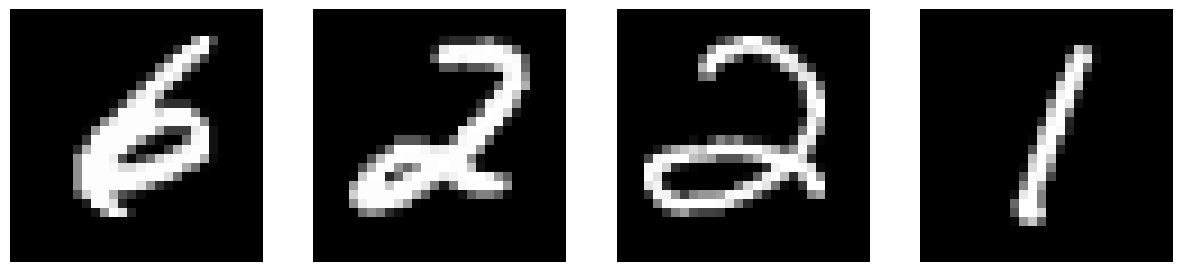

In [6]:
for x, y in train_dl:
    print(x.shape, y.shape)
    break

num = 4
img = x[:num]

plt.figure(figsize=(15, 15))
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.axis('off')
    plt.imshow(to_pil_image(img[i]*mean + std), cmap='gray')

# Define Teacher Model

In [7]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.8)
        x = self.fc3(x)
        return x

In [8]:
x = torch.randn(16, 1, 28, 28).to(device)
teacher = Teacher().to(device)
output = teacher(x)

print(output.argmax(axis=1))
print(output.size())

tensor([9, 7, 9, 5, 0, 6, 1, 3, 5, 6, 6, 7, 6, 1, 9, 8], device='cuda:1')
torch.Size([16, 10])


In [9]:
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('fc1') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

teacher.apply(init_weights)

Teacher(
  (fc1): Linear(in_features=784, out_features=1200, bias=True)
  (bn1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1200, out_features=1200, bias=True)
  (bn2): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1200, out_features=10, bias=True)
)

# Train Teacher Model

In [22]:
loss_func = nn.CrossEntropyLoss()
optim = optim.Adam(teacher.parameters())

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=10)

AttributeError: 'Adam' object has no attribute 'Adam'

In [11]:
def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

def metric_batch(output, target):
    pred = output.argmax(axis=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, optim=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if optim is not None:
        optim.zero_grad()
        loss_b.backward()
        optim.step()

    return loss_b.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, optim=None):
    run_loss = 0.0
    run_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, optim)

        run_loss += loss_b
        run_metric += metric_b

        if sanity_check is True:
            break

    loss = run_loss / len_data
    metric = run_metric / len_data
    return loss, metric

def train_val(model, params):
    num_epochs = params['epoch']
    loss_func = params['loss_func']
    optim = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {'train':[], 'val':[]}
    metric_history = {'train':[], 'val':[]}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optim)
        print(f'Epoch {epoch}/{num_epochs-1} current lr = {current_lr}')

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, optim)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(optim):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history            

# Train

In [12]:
params_train = {
    'epoch':30,
    'optimizer':optim,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [13]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

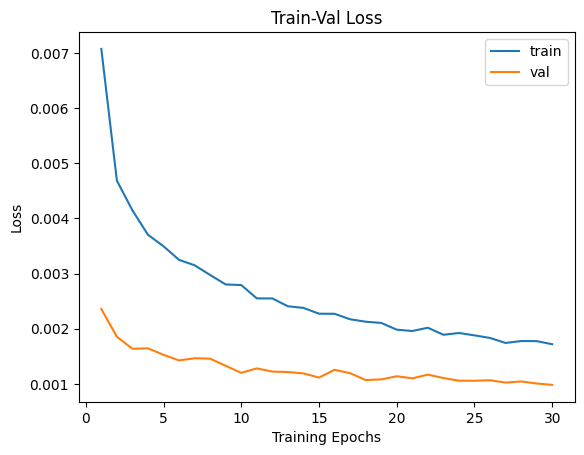

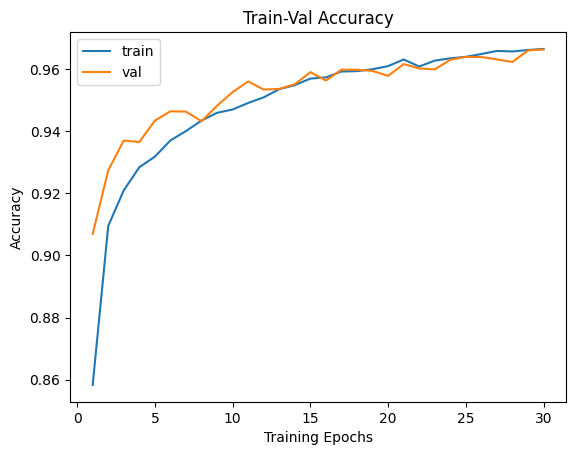

In [14]:
num_epochs = params_train['epoch']

plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Define Student Model

In [15]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [16]:
x = torch.randn(16,1,28,28).to(device)
student = Student().to(device)
output = student(x)
print(output.size())

torch.Size([16, 10])


In [17]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

student.apply(initialize_weights)

Student(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=800, bias=True)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=800, out_features=10, bias=True)
)

# Knowledge Distillation

In [24]:
teacher = Teacher().to(device)
teacher.load_state_dict(torch.load('./models/teacher_weights.pt'))

student = Student().to(device)

In [25]:
optimizer = optim.Adam(student.parameters())

def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

In [27]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=optim):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [31]:
num_epochs= 100

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(optimizer)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=optimizer)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/99, current lr= 0.001


/tmp/ipykernel_422644/2816120401.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
/tmp/ipykernel_422644/2816120401.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train loss: 0.035208, val loss: 0.000879, accuracy: 97.25, time: 0.2032 min
----------
Epoch 1/99, current lr= 0.001
train loss: 0.030244, val loss: 0.000736, accuracy: 97.59, time: 0.4004 min
----------
Epoch 2/99, current lr= 0.001
train loss: 0.029497, val loss: 0.000716, accuracy: 97.59, time: 0.5975 min
----------
Epoch 3/99, current lr= 0.001
train loss: 0.029301, val loss: 0.000638, accuracy: 97.84, time: 0.7942 min
----------
Epoch 4/99, current lr= 0.001
train loss: 0.029050, val loss: 0.000608, accuracy: 97.89, time: 0.9938 min
----------
Epoch 5/99, current lr= 0.001
train loss: 0.029058, val loss: 0.000610, accuracy: 97.92, time: 1.1916 min
----------
Epoch 6/99, current lr= 0.001
train loss: 0.028947, val loss: 0.000602, accuracy: 97.93, time: 1.3885 min
----------
Epoch 7/99, current lr= 0.001
train loss: 0.028762, val loss: 0.000566, accuracy: 98.00, time: 1.5932 min
----------
Epoch 8/99, current lr= 0.001
train loss: 0.028588, val loss: 0.000571, accuracy: 98.09, time:

In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()